# Ejercicio 1

Para esta seccion, seleccionamos un corpus de la biblioteca nltk. Para este ejercicio seleccionamos el corpus **cess_es**. Este corpus consiste un texto de noticias en espanol

In [22]:
import re
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import math   

from preprocesador import *
from subword import *
from frecuencias import *

os.environ["NLTK_DATA"]="datos_nltk/"
import  nltk
from nltk.corpus import stopwords

## Paso 1
Nos aseguramos de tener disponible el corpus **cess_esp**. Aprovechamos la funcionalidad de nltk para obtener las oraciones del corpus.




In [3]:
## Seleccionamos un corpus en español que se encuentra en nltk
from nltk.corpus import cess_esp

nltk.download("cess_esp")

## Obtenemos las oraciones del corpus para el entrenamiento de nuestra red neuronal
corpus_sents = cess_esp.sents()

print("Numero de oraciones en el corpus:", len(corpus_sents))

[nltk_data] Downloading package cess_esp to /home/joel/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


Numero de oraciones en el corpus: 6030


## Paso 2
Aplicamos un pre procesamiento a todos los tokens de nuestro corpus. Los pasos a seguir en nuestro pre procesamiento son los siguientes:
- Pasamos todos los tokens a minusculas
- Eliminamos cualquier signo de puntacion en los tokens, es decir, eliminamos cualquier signo que no sea una letra del alfabeto en español o número
- Eliminamos todos los tokens que sean identificados como _stopword_. Para la lista de _stopword_ utilizamos la lista encontrada en ntlk para el lenguaje de español
- Finalmente eliminamos acentos. En este paso, para cada token, sustituimos sus vocales acentuadas por la misma vocal sin acento.



In [4]:
# Procedemos a normalizar el texto:
# Removiendo acentos, puntuacion y stopwords

nltk.download('stopwords')
stopwords_list = stopwords.words('spanish')

# Normalizamos los oraciones
sents_norm = [pre_procesar(oracion, stopwords_list) for oracion in corpus_sents]

# Obtenemos todas las palabras del texto
tokens_normalizados = [x for xs in sents_norm for x in xs]

print("Numero de tokens, despues del preprocesamiento:", len(tokens_normalizados))

[nltk_data] Downloading package stopwords to /home/joel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Numero de tokens, despues del preprocesamiento: 86640


## Paso 3

Dado nuestros tokens normalizados, procedemos a realizar a obtener sub words utilizando BPE.

In [5]:
# Entrenamos nuestro algoritmo de BPE con las palabras del corpus, obtenemos las reglas y las frecuencias de cada token
# Aplicamos 500 iteraciones
freqs_bpe, reglas_bpe = entrenar_byte_pair_encoding(tokens_normalizados, 500)

In [6]:
## Aplicamos nuestro modelo bpe a cada oraciond el corpus para obtener las oraciones tokenizadas
sents_tokenizadas = [aplicar_bpe(sent, reglas_bpe) for sent in sents_norm]

## Agregamos las etiquetas <BOS> y <EOS> a cada oracion
sents_tokenizadas = [["<BOS>"] + sent + ["<EOS>"] for sent in sents_tokenizadas]


In [7]:
# Comparacion de la primera frase en palabras y tokenizadas con BPE
print(sents_tokenizadas[0])
print(sents_norm[0])

['<BOS>', 'grupo', 'estatal', 'elec', 'tri', 'ci', 'te', 'de', 'fran', 'ce', 'e', 'd', 'f', 'anuncio', 'hoy', 'jue', 'ves', 'co', 'mp', 'ra', '5', '1', 'porciento', 'empresa', 'mexi', 'cana', 'elec', 'tri', 'ci', 'dadagui', 'lade', 'al', 'ta', 'mira', 'e', 'a', 'a', 'cre', 'ada', 'japones', 'mi', 't', 'subis', 'hi', 'cor', 'poration', 'ponerenmar', 'cha', 'central', 'gas', '4', '9', '5', 'me', 'ga', 'vatios', '<EOS>']
['grupo', 'estatal', 'electricitedefrance', 'edf', 'anuncio', 'hoy', 'jueves', 'compra', '51porciento', 'empresa', 'mexicana', 'electricidadaguiladealtamira', 'eaa', 'creada', 'japones', 'mitsubishicorporation', 'ponerenmarcha', 'central', 'gas', '495', 'megavatios']


In [8]:
# Tabla para ver las frecuencias de las palabras
tabla_frecuencias_bpe = crear_tabla_frecuencias(freqs_bpe)
print(tabla_frecuencias_bpe)


        palabra  frecuencia
0             a        2253
1             o        2096
2            de        2036
3            co        1816
4            to        1574
...         ...         ...
9867    eratica           1
9868       raya           1
9869  chabacana           1
9870       arau           1
9871    coronar           1

[9872 rows x 2 columns]


In [9]:
#Convertimos la tabla en un diccionario para usarlo en el modelo
palabras = tabla_frecuencias_bpe['palabra']
frecuencias = tabla_frecuencias_bpe['frecuencia']
dic_palabras = {}  
for i in range(len(frecuencias)):
    dic_palabras[palabras[i]] = frecuencias[i]

In [11]:
ETIQUETA_UNK = "<UNK>"
def indices_palabras(palabras_frecuencias: dict):
    """Calcula los indices de las palabras dadas sus frecuencias

    Parameters
    ----------
    palabras_frecuencias : dict
        Diccionario donde las llaves son las palabras y los valores sus frecuencias

    Returns
    -------
    dict,dict
        Diccionarios uno a uno de palabras a indices y viceversa
    """
    result = {}
    for ind, palabra in enumerate(palabras_frecuencias.keys()):
        # Ocurrio un Happax legomena o singleton
        if palabras_frecuencias[palabra] == 1:
            # Indice temporal para UNK
            result[ETIQUETA_UNK] = len(palabras_frecuencias)
        else:
            result[palabra] = ind

    return {word: idx for idx, word in enumerate(result.keys())}, {idx: word for idx, word in enumerate(result.keys())}

In [12]:
#Se obtienen los índices de cada palabra
palabras_a_indices, indices_a_palabras = indices_palabras(dic_palabras)
print(palabras_a_indices)
print(indices_a_palabras)

{'a': 0, 'o': 1, 'de': 2, 'co': 3, 'to': 4, 'do': 5, 're': 6, 'ta': 7, 'e': 8, 'te': 9, 'con': 10, 'i': 11, 'ca': 12, 'se': 13, 'di': 14, 'da': 15, 'mo': 16, 'al': 17, 's': 18, 'dad': 19, 'c': 20, 'mi': 21, 'cion': 22, 'ma': 23, 't': 24, 'en': 25, 'l': 26, 'ar': 27, 'es': 28, 'p': 29, 'le': 30, 'in': 31, 'li': 32, 'si': 33, 'z': 34, 'd': 35, 'mente': 36, 'ex': 37, 'f': 38, 'ti': 39, 'fi': 40, 'go': 41, 'cia': 42, 'g': 43, 'ri': 44, 'cu': 45, 'k': 46, 'su': 47, 'vi': 48, 'lo': 49, 'dos': 50, 'que': 51, 'car': 52, 'per': 53, 'pro': 54, 'me': 55, 'des': 56, 've': 57, 'ci': 58, 'tas': 59, 'ce': 60, 'an': 61, 'mos': 62, '2': 63, 'ter': 64, 'pe': 65, 'os': 66, 'tos': 67, 'pi': 68, 'mas': 69, 'mar': 70, 'm': 71, 'tar': 72, 'ro': 73, 'por': 74, 'ra': 75, 'u': 76, '7': 77, 'ver': 78, 'so': 79, 'za': 80, 'hoy': 81, 'man': 82, '4': 83, 'lle': 84, 'no': 85, '3': 86, '6': 87, 'y': 88, 'la': 89, 'tan': 90, 'jo': 91, 'miento': 92, 'cos': 93, 'tu': 94, '5': 95, 'vo': 96, 'ga': 97, 'dis': 98, '8': 99, 

In [13]:
def get_id(palabra_a_id: dict, palabra: str) -> int:
    """Obtiene el id de una palabra dada

    Si no se encuentra la palabra se regresa el id
    del token UNK

    Parameters
    ----------
    palabra_a_id : dict
        Diccionario de palabras a indices
    palabra : str
        Palabra a buscar

    Returns
    -------
    int
        Indice de la palabra
    """
    id_unknow = palabra_a_id[ETIQUETA_UNK]
    return palabra_a_id.get(palabra, id_unknow)

## Paso 4
Definimos los bigramas a usar para entrenar nuestra red neuronal

In [14]:
def lista_bigramas(corpus:list, palabras_a_indices:dict) -> list:
    """Obtiene bigramas para usar en un modelo de red neuronal
    Parameters
    ----------
    corpus : list
        corpus a procesar
    indices_a_palabras : dict
        Diccionario de palabras a indices
    Returns
    -------
    list
        Conjunto de bigramas
    """
    bigramas = []
    for i in range(len(corpus)-1):
        bigrama = [get_id(palabras_a_indices, corpus[i]), get_id(palabras_a_indices, corpus[i+1])]
        bigramas.append(bigrama)
    return bigramas

In [15]:
#Obtenemos los bigramas
bigramas = lista_bigramas(tokens_normalizados, palabras_a_indices)
print(bigramas)

[[372, 2415], [2415, 6038], [6038, 6038], [6038, 708], [708, 81], [81, 6038], [6038, 6038], [6038, 6038], [6038, 607], [607, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 1539], [1539, 6038], [6038, 6038], [6038, 1159], [1159, 266], [266, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 732], [732, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 266], [266, 1515], [1515, 6038], [6038, 6038], [6038, 1159], [1159, 6038], [6038, 6038], [6038, 481], [481, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 2516], [2516, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 449], [449, 507], [507, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 2517], [2517, 670], [670, 102], [102, 6038], [6038, 1777], [1777, 6038], [6038, 6038], [6038, 1929], [1929, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6038, 6038], [6

## Paso 5

Construimos la red neuronal

In [27]:
#Inicializacion de hiperparámetros

np.random.seed(42) #Seed para la reproductibilidad
N = len(palabras_a_indices.keys()) #Longitud del vocabulario
d = 2 #Dimensión de los embeddings
m = N #Número de unidades en la capa oculta
taza_aprend = 0.1 #Rango de aprendizaje
EPOCHS = 100 #Número de iteraciones para entrenamiento

In [28]:
#Inicialización de parámetros
C = np.random.randn(d, N) / np.sqrt(N)
W =  np.random.randn(m, d) / np.sqrt(d)
b = np.random.randn(m) / np.sqrt(m)
U = np.random.randn(N,m) / np.sqrt(m)
c = np.random.randn(N) / np.sqrt(N)

In [29]:
#Función para construir el vector one-hot de una palabra a partir de su índice
def crear_one_hot(ind : int, size : int) -> list:
    onehot = np.zeros(size)
    onehot[ind] = 1
    return onehot

In [31]:
losses = []
for epoch in range(EPOCHS):
    # Acumula el riesgo de la epoch
    loss = 0
    for bigrama in bigramas:
        one_hot = crear_one_hot(bigrama[0], N)

        #Embedding
        Ci = np.dot(C,one_hot)

        #Capa oculta
        WCi = np.dot(W, Ci)
        tanh = np.vectorize(lambda x: math.tanh(x))
        hi = tanh(WCi + b)
        #Pre-activacion
        ai = np.dot(U, hi) + c

        #activacion
        f = []
        npexp = np.vectorize(lambda x: math.exp(x))
        expai = npexp(ai) 
        for aj in ai:
            f.append(math.exp(aj) / expai.sum())
                
        # Calcula loss por ejemplo
        loss += -np.log(f)[bigrama[1]]

        # Backpropagation
        # Variable de salida
        d_out = f
        d_out[bigrama[1]] -= 1

        U -= (taza_aprend * np.outer(d_out, hi))

        for i in range(len(b)):
            b[i] -= taza_aprend * d_out[i]
            
        
        dh = np.dot(d_out, U) * (1-(hi**2))
        W -= (taza_aprend * np.outer(dh, Ci))

        for i in range(len(c)):
            c[i] -= taza_aprend * dh[i]

        dc = np.dot(dh, W)
        C -= (taza_aprend * np.outer(dc, one_hot))

    # Guardamos el loss
    losses.append(loss)
    print(f"Epoch {epoch}, loss: {loss}")

Epoch 0, loss: 289922.9388060227
Epoch 1, loss: 250326.17667303147
Epoch 2, loss: 244940.61620955195
Epoch 3, loss: 242532.2971280545
Epoch 4, loss: 241231.1273220257
Epoch 5, loss: 240453.1969871036
Epoch 6, loss: 239942.33849383116
Epoch 7, loss: 239586.75221073345
Epoch 8, loss: 239322.36352875558
Epoch 9, loss: 239114.9873484633
Epoch 10, loss: 238946.8432563231
Epoch 11, loss: 238807.685645096
Epoch 12, loss: 238690.86494673678
Epoch 13, loss: 238591.61713961948
Epoch 14, loss: 238506.38138465924
Epoch 15, loss: 238432.47302625474
Epoch 16, loss: 238367.8436181393
Epoch 17, loss: 238310.90322007623
Epoch 18, loss: 238260.40175806466
Epoch 19, loss: 238215.34854697296
Epoch 20, loss: 238174.9474222316
Epoch 21, loss: 238138.54155047218
Epoch 22, loss: 238105.57696422515
Epoch 23, loss: 238075.58357883993
Epoch 24, loss: 238048.16514122984
Epoch 25, loss: 238022.99783269054
Epoch 26, loss: 237999.84917600846
Epoch 27, loss: 237978.6257174183
Epoch 28, loss: 237959.33386299587
Epoch 

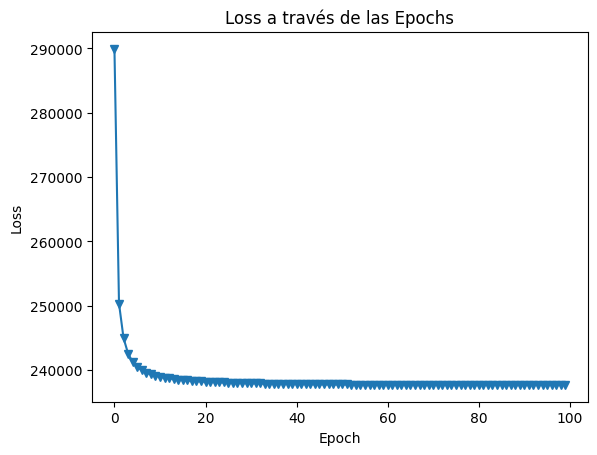

In [32]:
plt.plot(losses, 'v-')
plt.title('Loss a través de las Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [33]:
def forward(ind_palabra : int, N : int):
    #Obtener one-hot
    one_hot = crear_one_hot(ind_palabra, N)

    #Embedding
    Ci = np.dot(C,one_hot)
    
    #Capa oculta
    WCi = np.dot(W, Ci)
    tanh = np.vectorize(lambda x: math.tanh(x))
    hi = tanh(WCi + b)

    #Pre-activacion
    ai = np.dot(U, hi) + c

    #Activacion
    probas = []
    npexp = np.vectorize(lambda x: math.exp(x))
    expai = npexp(ai) 
    for aj in ai:
        probas.append(math.exp(aj) / expai.sum())
    return probas

In [38]:
word = "plazo"
probabilities = sorted(
    list(zip(palabras_a_indices.keys(), forward(palabras_a_indices[word], len(palabras_a_indices.keys())))),
    key=lambda x: x[1],
    reverse=True
)
print(probabilities[:20])

[('teleno', 0.007195876431861312), ('nobles', 0.004058799975941319), ('entan', 0.0036732884589381377), ('previas', 0.0032833295594584845), ('loren', 0.00306594283849674), ('pablo', 0.002827214057012073), ('grano', 0.0024570615911091906), ('mpato', 0.0021854020164905658), ('peru', 0.0019278677135876657), ('casada', 0.0018647068877805434), ('reuni', 0.001805211396925355), ('quini', 0.0017997739146611122), ('conmirasa', 0.0017926577339196826), ('subrayo', 0.0017416335615426624), ('mbre', 0.0016168847188958821), ('mado', 0.0016042229222246738), ('regis', 0.001598542613474743), ('siendo', 0.0015792804017025967), ('misi', 0.001488330510805614), ('queria', 0.0014304459540547796)]
